In [4]:

import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import PIL.ImageOps

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import torchvision.utils
import torch
from torch.autograd import Variable
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import pickle
from tqdm import tqdm
from sklearn.model_selection import train_test_split
device = torch.device('cuda')
print(torch.cuda.is_available())
print('adam')

NameError: name '_C' is not defined

In [2]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,person,signals):
        self.person = person
        self.signals = signals

    def __getitem__(self,index):
        should_get_same_class = random.randint(0,1)
        person0_index = random.choice(range(len(self.person)))
        if should_get_same_class:
            while True:
                person1_index = random.choice(range(len(self.person)))
                if (self.person[person1_index] == self.person[person0_index]) and (person1_index != person0_index):
                    break
        else:
            while True:
                person1_index = random.choice(range(len(self.person)))
                if (self.person[person1_index] != self.person[person0_index]):
                    break

        signals0 = self.signals[person0_index]
        signals1 = self.signals[person1_index]


        return signals0, signals1, should_get_same_class

    def __len__(self):
        return len(self.person)

NameError: name 'Dataset' is not defined

In [6]:
batch_size =4
filename = 'data\my_data\data.pickle'
with open(filename, 'rb') as f:
    data  = pickle.load(f)
person  = data['person']
signals = data['signal']

person = torch.tensor(person)
signals = torch.tensor(signals)

person_train, person_test, signals_train, signals_test = train_test_split(
    person, signals, test_size=0.3, shuffle=True, random_state=42)

person_valid, person_test, signals_valid, signals_test = train_test_split(
    person_test, signals_test, test_size=0.5, shuffle=True, random_state=42)

trian_dataset = SiameseNetworkDataset(person_train,signals_train)
trian_dataloder = torch.utils.data.DataLoader(trian_dataset, batch_size=batch_size, shuffle=True)


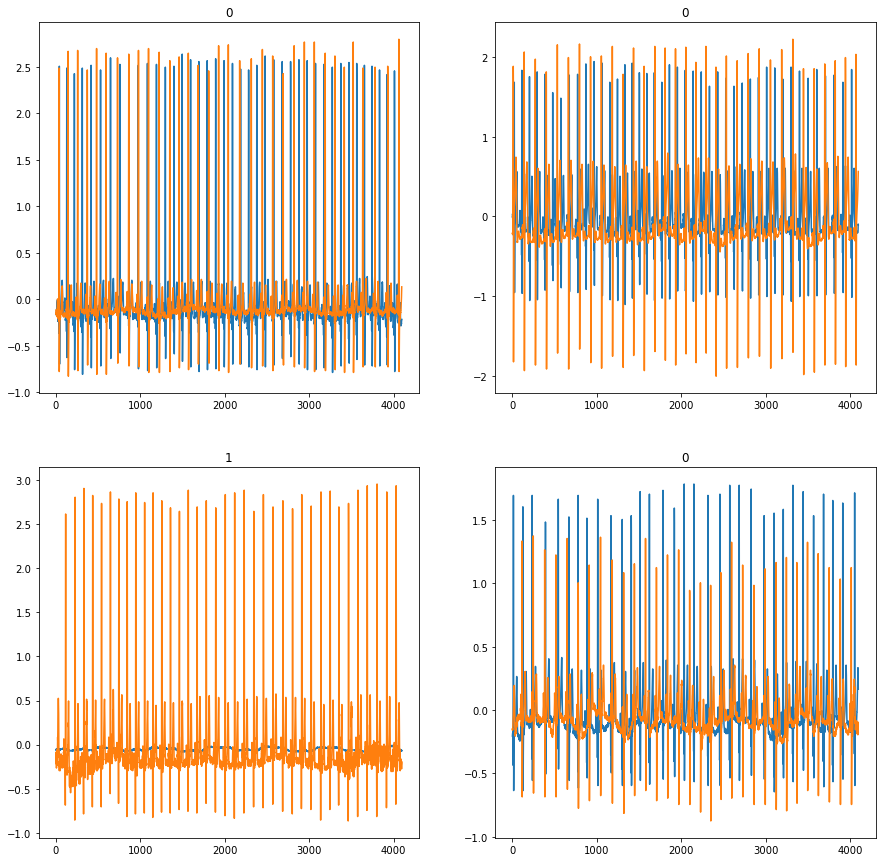

<Figure size 576x576 with 0 Axes>

In [7]:
example_batch = next(iter(trian_dataloder))
example0 = example_batch[0]
example1 = example_batch[1]
labels = example_batch[2].numpy()

fig,axes = plt.subplots(2,2,figsize=(15,15))
plt.figure(figsize=(8,8))
for i, ax in enumerate(axes.flatten()):
    ax.plot(example0[i].numpy())
    ax.plot(example1[i].numpy())
    ax.set_title(str(labels[i]))




In [139]:
class SiameseNetwork(nn.Module):

    def __init__(self):
        super(SiameseNetwork, self).__init__()

        self.cnn = nn.Sequential(
            # # block 1
            nn.Conv1d(in_channels = 1, out_channels=32,kernel_size=15,padding="same"),
            nn.BatchNorm1d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.05),

            # # block 2
            nn.Conv1d(in_channels = 32, out_channels=64,kernel_size=15,padding="same"),
            nn.BatchNorm1d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.05),

            # # block 3
            nn.Conv1d(in_channels = 64, out_channels=128,kernel_size=15,padding="same"),
            nn.BatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.05),

            # # block 4
            nn.Conv1d(in_channels = 128, out_channels=256,kernel_size=15,padding="same"),
            nn.BatchNorm1d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.05),

            # # block 5
            nn.Conv1d(in_channels = 256, out_channels=14*32,kernel_size=15,padding="same"),
            nn.BatchNorm1d(14*32),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(kernel_size=2),
            nn.Dropout(p=0.05)
        )
        self.fc = nn.Sequential(
            nn.Linear(in_features=14*32*128,out_features=14*32,bias=True)
        )
    def forward(self, input1, input2):
        output1 = self.cnn(input1)
        print('a')
        output2 = self.cnn(input2)
        print('a')
        output1 = output1.view(output1.shape[0],-1)
        print('a')
        output2 = output2.view(output2.shape[0],-1)
        print('a')
        output1 = self.fc(output1)
        print('a')
        output2 = self.fc(output2)
        return output1, output2

In [137]:
# how can we calcualte the output of the convolution automatically?
dummy_input1 = torch.zeros(4,1,4096)
dummy_input2 = torch.zeros(4,1,4096)
print(dummy_input1.size())
dummy_model = SiameseNetwork()
dummy_output1, dummy_output2= dummy_model.forward(dummy_input1,dummy_input2)
print(type(dummy_output1))
print(dummy_output1.size())
print(dummy_output2)


torch.Size([4, 1, 4096])
<class 'torch.Tensor'>
torch.Size([4, 448])
tensor([[-0.0038,  0.0017, -0.0027,  ...,  0.0009,  0.0022,  0.0008],
        [-0.0038,  0.0017, -0.0027,  ...,  0.0009,  0.0022,  0.0008],
        [-0.0038,  0.0017, -0.0027,  ...,  0.0009,  0.0022,  0.0008],
        [-0.0038,  0.0017, -0.0027,  ...,  0.0009,  0.0022,  0.0008]],
       grad_fn=<AddmmBackward0>)


In [113]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

In [ ]:
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [144]:
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr = 0.0005 )

counter = []
loss_history = []
iteration_number= 0
epochs = 10
# Iterate throught the epochs
for epoch in range(epochs):

    # Iterate over batches
    for i, (signal1, signal2, label) in enumerate(trian_dataloder, 0):
        signal1 = signal1.view(signal1.shape[0],1,signal1.shape[1])
        signal2 = signal2.view(signal2.shape[0],1,signal2.shape[1])
        # Send the images and labels to CUDA
        # Zero the gradients
        optimizer.zero_grad()

        signal1 = signal1.to(device=device, dtype=torch.float)
        signal2 = signal2.to(device=device, dtype=torch.float)
        label = label.to(device=device, dtype=torch.float)


        # Pass in the two images into the network and obtain two outputs
        output1, output2 = net(signal1, signal2)
        # Pass the outputs of the networks and label into the loss function
        loss_contrastive = criterion(output1, output2, label)

        # Calculate the backpropagation
        loss_contrastive.backward()

        # Optimize
        optimizer.step()

        # Every 10 batches print out the loss
        if i % 100 == 0 :
            print(f"Epoch number {epoch}\n Current loss {loss_contrastive.item()}\n")
            iteration_number += 10

            counter.append(iteration_number)
            loss_history.append(loss_contrastive.item())

show_plot(counter, loss_history)



torch.Size([4, 1, 4096])


NotImplementedError: 

In [195]:
available_gpus = [torch.cuda.device(i) for i in range(torch.cuda.device_count())]

In [110]:
print(torch.cuda.device_count())
print(torch.cuda.is_available())
print('adam')

0
False
adam


In [198]:
from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

['/device:GPU:0']


In [36]:
a =torch.tensor(0,device = 'cudnn')
# print(torch.get_all_devices()

RuntimeError: Invalid device string: '/device:GPU:0'

In [39]:
print(torch.backends.cudnn.enabled)

True


In [34]:

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']
print(get_available_gpus())

['/device:GPU:0']
